<h2>Load dataset</h2>

In [1]:
###############################################################
import pydicom as dicom
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.transform
from skimage import exposure
from scipy.ndimage import zoom
import cv2

In [2]:
#################################################################
dcm_ext = '.dcm'
def laod_single_volume(folder_path):
    '''
        This function returns a tuple with the volume of a single patient and its mean voxel dimension
    '''
    img_vol = []
    voxel_z = []
    voxel_x = []
    voxel_y = []
    for path, _, files in sorted(os.walk(folder_path)): 
      for filename in (sorted(files)): 
          if filename.endswith (dcm_ext):
            #print (filename)
            img_dcm_std = dicom.dcmread(os.path.join(folder_path,filename))

            img = img_dcm_std.pixel_array
            img_vol.append (img)
            
            voxel_z.append (img_dcm_std.SpacingBetweenSlices)
            voxel_x.append (img_dcm_std.PixelSpacing [0])
            voxel_y.append (img_dcm_std.PixelSpacing [1])
      
      voxel_z = np.array(voxel_z)
      voxel_x = np.array(voxel_x)
      voxel_y = np.array(voxel_y)      
      z_space = voxel_z.mean()
      x_space = voxel_x.mean()
      y_space = voxel_y.mean()
      vox_dim = (x_space, y_space, z_space)
    return (np.array(img_vol),vox_dim)

In [3]:
#######################################################################################
#Load an array of volumes
volumes = []
vox_sizes = []
root_path="./CHAOS_Train_Sets/Train_Sets/MR/"

for subdir in os.listdir(root_path):
    vol, dim = laod_single_volume(root_path+subdir+"/T1DUAL/DICOM_anon/InPhase")
    volumes.append(vol)
    vox_sizes.append(dim)
    #vol, dim = laod_single_volume(root_path+subdir+"/T1DUAL/DICOM_anon/OutPhase")
    #volumes.append(vol)
    #vox_sizes.append(dim)
    


In [4]:
print(volumes[0].shape)

(35, 256, 256)


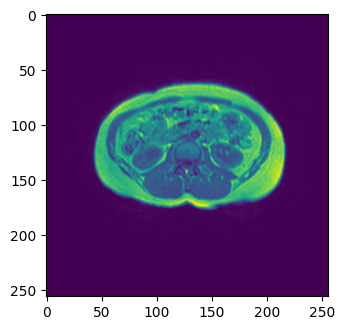

In [5]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(volumes[0] [5, :, :])


<h2>Normalize voxel dimension</h2>

In [6]:

###############################################################################################
#Compute mean voxel dimension
vox_sizes = np.array(vox_sizes)
target_resolution = vox_sizes.mean(axis = 0)


In [7]:
print(target_resolution)

[1.64887152 1.64887152 8.275     ]


In [8]:
#################################################################################################
#Normalize volumes
for i in range(0,len(volumes)):
    scale_vector = (vox_sizes[i][0]/target_resolution[0],vox_sizes[i][1]/target_resolution[1],vox_sizes[i][1]/target_resolution[1])
    volumes[i] = skimage.transform.rescale(volumes[i],scale_vector, order = 3, preserve_range=True, mode='constant')
    

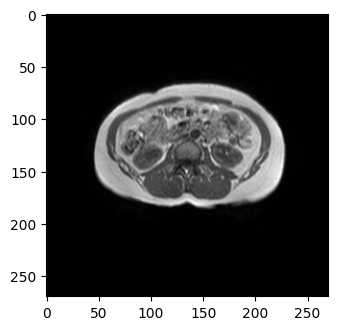

In [9]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(volumes[0] [5, :, :], cmap = 'gray')

<h2>Reshape slices</h2>

In [10]:
target_shape = [33, 256, 256]

for i in range(0,len(volumes)):
    factors = (
        target_shape[0]/volumes[i].shape[0],
        target_shape[1]/volumes[i].shape[1],
        target_shape[2]/volumes[i].shape[2]
    )
    volumes[i] = zoom (volumes[i], factors, order = 3, mode = 'nearest')

In [11]:
print(volumes[2].shape)

(33, 256, 256)


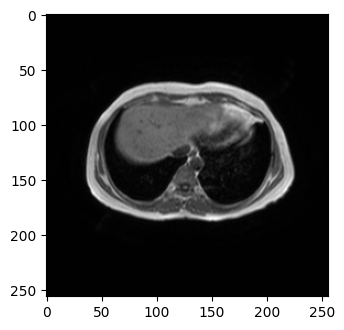

In [12]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(volumes[0] [30, :, :], cmap = 'gray')

<h3>max min and distribution normalization</h3>

In [13]:
##Normalize image distribution
volumes_o = np.float32(volumes.copy())
m = np.mean(volumes_o)
s = np.std(volumes_o)
normalized_volumes = np.divide((volumes_o - m ),s)

In [14]:
volumes_o = np.divide(volumes - np.min(volumes),np.max(volumes) - np.min(volumes))

<h3>Save the dataset</h3>

In [15]:
#save dataset
np.save("./normalized_dataset",volumes_o)

<h3>Reshape masks</h3>

In [16]:
#################################################################
from PIL import Image

dcm_ext = '.png'
def laod_volume_labels(folder_path):
    img_vol = []
    for path, _, files in sorted(os.walk(folder_path)): 
      for filename in (sorted(files)): 
          if filename.endswith (dcm_ext) and int(filename[-6:-5])%2 == 0:
            #print (filename)
            label_img = np.array(Image.open(os.path.join(folder_path,filename)))
            img_vol.append (label_img)
    return np.array(img_vol)

In [17]:
#######################################################################################
#Load an array of volumes of masks
vols_labels = []

root_path="./CHAOS_Train_Sets/Train_Sets/MR/"

for subdir in os.listdir(root_path):
    lab_vol = laod_volume_labels(root_path+subdir+"/T1DUAL/Ground/")
    vols_labels.append(lab_vol)
    
    #vol, dim = laod_single_volume(root_path+subdir+"/T1DUAL/DICOM_anon/InPhase")
    #volumes.append(vol)
    #vox_sizes.append(dim)
    
    #vol, dim = laod_single_volume(root_path+subdir+"/T1DUAL/DICOM_anon/OutPhase")
    #volumes.append(vol)
    #vox_sizes.append(dim)
    


In [18]:
target_shape = [33, 256, 256]

In [19]:
#RESHAPE MASKS
for i in range(0,len(vols_labels)):
    factors = (
        target_shape[0]/vols_labels[i].shape[0],
        target_shape[1]/vols_labels[i].shape[1],
        target_shape[2]/vols_labels[i].shape[2]
    )
    vols_labels[i] = zoom (vols_labels[i], factors, order = 0, mode = 'nearest')

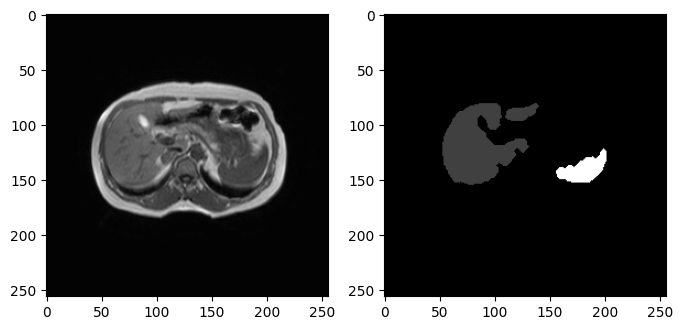

In [20]:
#Visualize mask
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)

imgplot = plt.imshow(volumes[0] [19, :, :], cmap = 'gray')
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(vols_labels[0] [19, :, :], cmap = 'gray')


In [21]:
vols_labels = np.array(vols_labels)
print(vols_labels.shape)

(20, 33, 256, 256)


In [ ]:
#save masks
np.save("./labels",vols_labels)